In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os
import tqdm

import warnings

warnings.filterwarnings('ignore')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, \
    ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
class MapColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, mapping=None):
        self.column = column
        self.mapping = mapping or {
            # Organic
            "organic": "organic",
            "(none)": "organic",
            "referral": "organic",

            # CPC
            "cpc": "paid_cpc",
            "yandex_cpc": "paid_cpc",
            "google_cpc": "paid_cpc",

            # CPM
            "cpm": "paid_cpm",
            "CPM": "paid_cpm",

            # Email
            "email": "email",
            "outlook": "email",

            # Social / SMM
            "push": "social",
            "smm": "social",
            "stories": "social",
            "post": "social",
            "blogger_channel": "social",
            "blogger_stories": "social",
            "blogger_header": "social",
            "tg": "social",
            "fb_smm": "social",
            "vk_smm": "social",
            "ok_smm": "social",
            "app": "social",
            "static": "social",

            # Partner/Promo
            "smartbanner": "partner",
            "partner": "partner",
            "promo_sber": "partner",
            "promo_sbol": "partner",
            "landing": "partner",
            "landing_interests": "partner",
            "link": "partner",
            "web_polka": "partner",
            "main_polka": "partner",
            "tablet": "partner",
            "desktop": "partner",
            "Sbol_catalog": "partner",
            "catalogue": "partner",
            "dom_click": "partner",

            # QR, rare
            "qr": "qr",
            "qrcodevideo": "qr"
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.column + "_mapped"] = X[self.column].apply(
            lambda x: self.mapping.get(str(x).lower(), "other") if isinstance(x, str) else "other")
        return X


In [ ]:
class TopEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, top_n=10, is_hash=False):
        self.column = column
        self.top_n = top_n
        self.is_hash = is_hash
        self.top_categories_ = None

    def fit(self, X, y=None):
        self.top_categories_ = X[self.column].value_counts().head(self.top_n).index.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        if self.is_hash:
            mapping = {cat: idx for idx, cat in enumerate(self.top_categories_)}
            mapping["other"] = self.top_n
            X[self.column + "_encoded"] = X[self.column].apply(lambda x: mapping.get(x, self.top_n))
        else:
            top_set = set(self.top_categories_)
            X[self.column + "_encoded"] = X[self.column].apply(lambda x: x if x in top_set else "other")
        return X


In [ ]:
class DatetimeFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_col, time_col):
        self.date_col = date_col
        self.time_col = time_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df["datetime"] = pd.to_datetime(df[self.date_col] + " " + df[self.time_col])

        df["day_of_week"] = df["datetime"].dt.dayofweek
        df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
        df["hour"] = df["datetime"].dt.hour
        df["month"] = df["datetime"].dt.month

        df["season"] = df["month"].apply(lambda m: (
            "winter" if m in [12, 1, 2] else
            "spring" if m in [3, 4, 5] else
            "summer" if m in [6, 7, 8] else "autumn"
        ))

        return df.drop(columns=["datetime", "month", "hour"])


In [ ]:
class FillNAAndStr(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].fillna('other').astype(str)
        return X


In [ ]:
class DropOriginalColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop, errors='ignore')

In [ ]:
custom_steps = Pipeline(steps=[
    ('map_medium', MapColumnTransformer(column='utm_medium')),
    ('encode_campaign', TopEncoderTransformer(column='utm_campaign', top_n=4, is_hash=True)),
    ('encode_source', TopEncoderTransformer(column='utm_source', top_n=7, is_hash=True)),
    ('encode_keyword', TopEncoderTransformer(column='utm_keyword', top_n=2, is_hash=True)),
    ('encode_device_os', TopEncoderTransformer(column='device_os', top_n=3)),
    ('encode_device_brand', TopEncoderTransformer(column='device_brand', top_n=4)),
    ('encode_device_browser', TopEncoderTransformer(column='device_browser', top_n=3)),
    ('encode_device_model', TopEncoderTransformer(column='device_model', top_n=1, is_hash=True)),
    ('encode_device_category', TopEncoderTransformer(column='device_category', top_n=1)),
    ('encode_geo_city', TopEncoderTransformer(column='geo_city', top_n=2)),
    ('encode_geo_country', TopEncoderTransformer(column='geo_country', top_n=1)),
    ('encode_visit_number', TopEncoderTransformer(column='visit_number', top_n=2)),
    ('datetime_features', DatetimeFeatureTransformer(date_col='visit_date', time_col='visit_time')),
    ('drop_orig', DropOriginalColumnsTransformer(columns_to_drop=[
        'utm_campaign', 'utm_source', 'utm_keyword', 'utm_medium', 'visit_number', 'visit_date', 'visit_time',
        'device_os', 'device_brand', 'device_browser', 'device_screen_resolution', 'device_category', 'device_model',
        'geo_city', 'geo_country'
    ])),
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def build_pipeline(model, cat_features, num_features):
    fillna_str = FillNAAndStr(columns=cat_features)

    preprocessor = Pipeline(steps=[
        ('custom', custom_steps),
        ('fillna_and_str', fillna_str),
        ('transform', ColumnTransformer([
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ], remainder='drop'))
    ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipeline


In [ ]:
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, solver='lbfgs'),
        "params": {
            'model__C': [0.01, 0.1, 1, 10]
        }
    },

    "DecisionTree": {
        "model": DecisionTreeClassifier(),
        "params": {
            'model__max_depth': [3, 5, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },

    "Bagging": {
        "model": BaggingClassifier(estimator=DecisionTreeClassifier(), n_jobs=-1),
        "params": {
            'model__n_estimators': [50, 100],
            'model__max_samples': [0.6, 0.8, 1.0],
            'model__max_features': [0.6, 0.8, 1.0]
        }
    },

    "RandomForest": {
        "model": RandomForestClassifier(n_jobs=-1),
        "params": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 10, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },

    "GradientBoosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    },

    "LightGBM": {
        "model": LGBMClassifier(),
        "params": {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__num_leaves': [31, 50],
            'model__max_depth': [-1, 10]
        }
    },

    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
        "params": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 6],
            'model__learning_rate': [0.05, 0.1],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        }
    },

    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            'model__iterations': [100, 200],
            'model__depth': [4, 6],
            'model__learning_rate': [0.05, 0.1],
            'model__l2_leaf_reg': [1, 3, 5]
        }
    },

    "ExtraTrees": {
        "model": ExtraTreesClassifier(n_jobs=-1, bootstrap=False),
        "params": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 10, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },

    "HistGradientBoosting": {
        "model": HistGradientBoostingClassifier(loss='log_loss'),
        "params": {
            'model__max_iter': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    }
}


In [ ]:
def save_roc_auc_plot(model_name, y_test, y_proba, version):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUC — {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{version}/plots/{model_name}_roc_auc.png")
    plt.show()
    plt.close()

In [ ]:
def save_feature_importance(model_pipeline, model_name, version, show_table=False):
    model = model_pipeline.named_steps['model']
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = model.coef_.ravel()
        else:
            print(f"Нет фичей для {model_name}")
            return

        feature_names = model_pipeline.named_steps['preprocessor'].named_steps['transform'].get_feature_names_out()

        # Создание таблицы
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)

        if show_table:
            print(f"\n🔎 Feature Importance — {model_name}:\n")
            display(importance_df.head(20))

        # Построение графика
        sorted_idx = importance_df.head(20).index
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), importance_df.loc[sorted_idx, 'importance'])
        plt.yticks(range(len(sorted_idx)), importance_df.loc[sorted_idx, 'feature'])
        plt.gca().invert_yaxis()
        plt.title(f'Feature Importance — {model_name}')
        plt.tight_layout()
        plt.savefig(f"{version}/plots/{model_name}_feature_importance.png")
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Feature importance error for {model_name}: {e}")


In [ ]:
def save_pipeline(grid, version, name):
    with open(f"{version}/models/{name}.pkl", "wb") as f:
        pickle.dump(grid.best_estimator_, f)

In [ ]:
def save_pipeline(grid, version, name):
    if not hasattr(grid, 'best_estimator_'):
        raise ValueError("GridSearchCV не обучен — нет best_estimator_")

    with open(f"{version}/models/{name}.pkl", "wb") as f:
        pickle.dump(grid.best_estimator_, f)

In [ ]:
def train_models_with_grid_search(X_train, X_test, y_train, y_test, version='new', show_table=False, model_names='all'):
    if model_names == 'all':
        model_names = models.keys()

    os.makedirs(f"{version}/models", exist_ok=True)
    os.makedirs(f"{version}/plots", exist_ok=True)

    auc_scores = {}

    for name in tqdm.tqdm(model_names, desc="Обучение моделей"):
        if name not in models:
            print(f"Модель {name} не найдена")
            continue

        cfg = models[name]
        print(f"\n GridSearch - {name}")

        # Признаки
        X_temp = custom_steps.fit_transform(X_train)

        num_features = X_temp.select_dtypes(include=['int64', 'float64']).columns.tolist()
        cat_features = X_temp.select_dtypes(include=['object']).columns.tolist()

        # Построение Pipeline
        pipeline = build_pipeline(cfg['model'], cat_features=cat_features, num_features=num_features)

        # GridSearch
        grid = GridSearchCV(
            pipeline,
            cfg['params'],
            cv=3,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )

        # GridSearch
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

        auc_scores[name] = auc

        print(f"{name} ROC AUC: {auc:.4f}")
        print(f"Best params: {grid.best_params_}")

        # Сохраняем модель
        save_pipeline(grid, version, name)

        # Сохраняем графики
        save_roc_auc_plot(name, y_test, y_proba, version)
        save_feature_importance(grid.best_estimator_, name, version, show_table)

    return auc_scores

In [ ]:
def plot_roc_auc_comparison(auc_scores, version):
    auc_scores = dict(sorted(auc_scores.items(), key=lambda x: x[1], reverse=True))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(auc_scores.keys(), auc_scores.values(), color='skyblue')
    plt.ylim(0.5, 1)
    plt.ylabel('ROC AUC')
    plt.title('Сравнение ROC AUC моделей')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height - 0.05, f"{height:.3f}", ha='center', color='black',
                 fontsize=10)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{version}/plots/roc_auc_comparison.png")
    plt.show()


In [ ]:
df = pd.read_csv('data/final_df.csv')
X = df.drop(columns='target')
y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

Обучение моделей:   0%|          | 0/10 [00:00<?, ?it/s]


 GridSearch - LogisticRegression
LogisticRegression ROC AUC: 0.7351
Best params: {'model__C': 0.01}


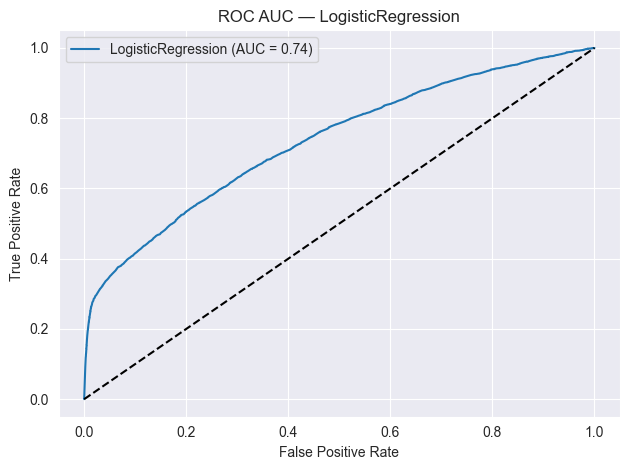


🔎 Feature Importance — LogisticRegression:



,feature,importance
35,cat__visit_number_encoded_other,1.302467
34,cat__visit_number_encoded_2,0.600012
37,cat__season_spring,0.483790
12,cat__utm_medium_mapped_social,0.143184
2,num__utm_keyword_encoded,0.124648
19,cat__device_brand_encoded_Samsung,0.097461
6,cat__utm_medium_mapped_organic,0.091984
28,cat__geo_city_encoded_Moscow,0.056614
5,cat__utm_medium_mapped_email,0.041031
16,cat__device_os_encoded_other,0.036349


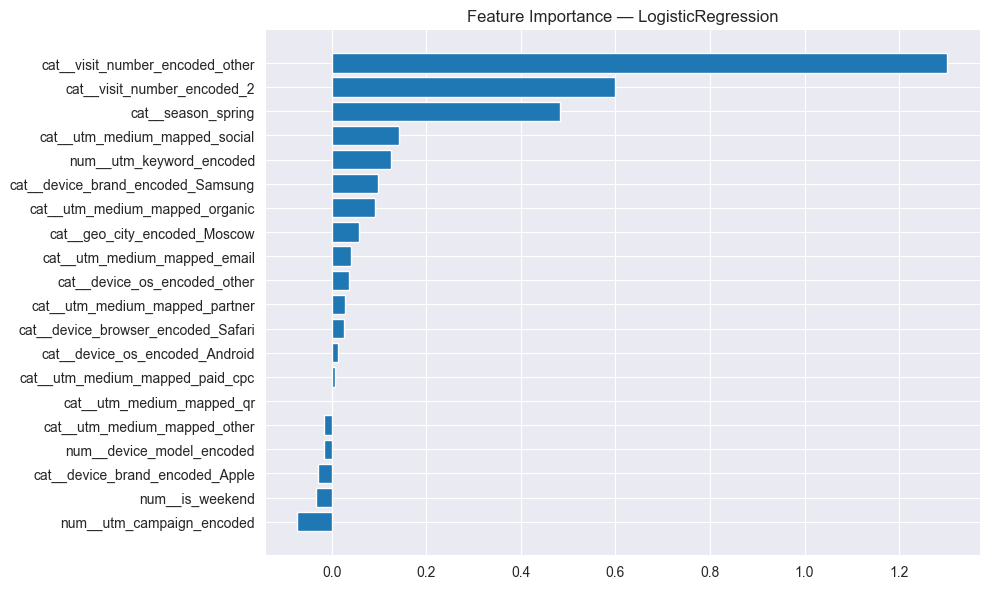

Обучение моделей:  10%|█         | 1/10 [00:36<05:29, 36.63s/it]


 GridSearch - DecisionTree
DecisionTree ROC AUC: 0.7653
Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}


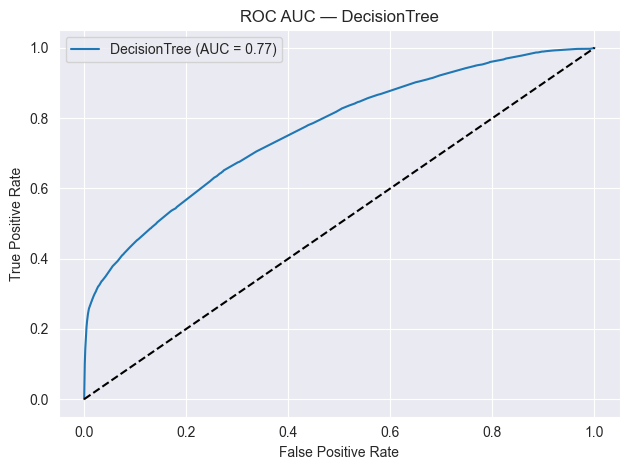


🔎 Feature Importance — DecisionTree:



,feature,importance
33,cat__visit_number_encoded_1,0.590408
1,num__utm_source_encoded,0.155467
0,num__utm_campaign_encoded,0.044421
34,cat__visit_number_encoded_2,0.031669
37,cat__season_spring,0.027254
16,cat__device_os_encoded_other,0.017380
17,cat__device_brand_encoded_Apple,0.013484
30,cat__geo_city_encoded_other,0.013045
38,cat__season_summer,0.013029
36,cat__season_autumn,0.007787


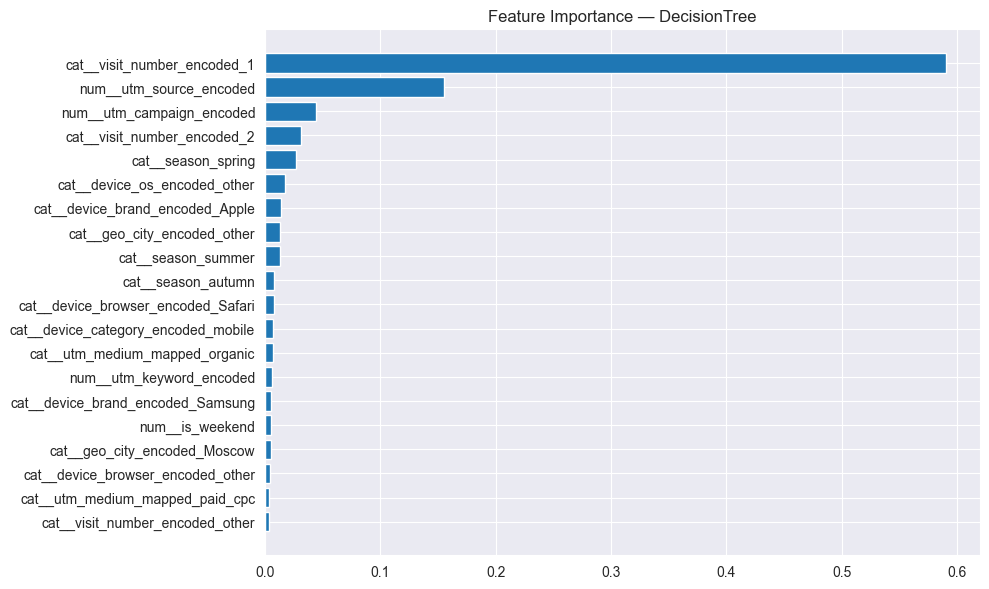

Обучение моделей:  20%|██        | 2/10 [02:46<12:13, 91.64s/it]


 GridSearch - Bagging
Bagging ROC AUC: 0.7729
Best params: {'model__max_features': 0.6, 'model__max_samples': 0.8, 'model__n_estimators': 100}


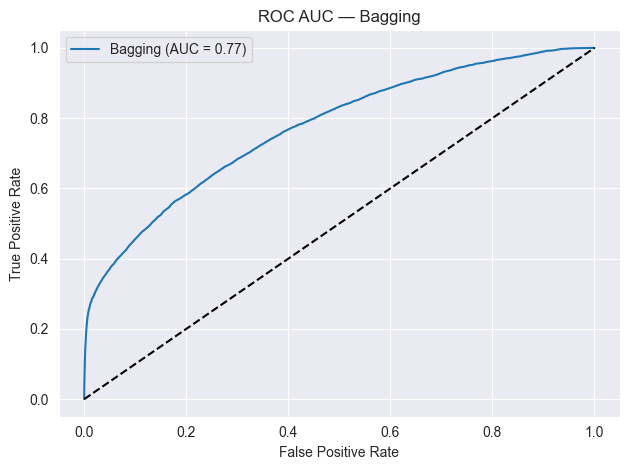

Обучение моделей:  30%|███       | 3/10 [17:59<54:24, 466.37s/it]

Нет фичей для Bagging

 GridSearch - RandomForest
RandomForest ROC AUC: 0.7698
Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}


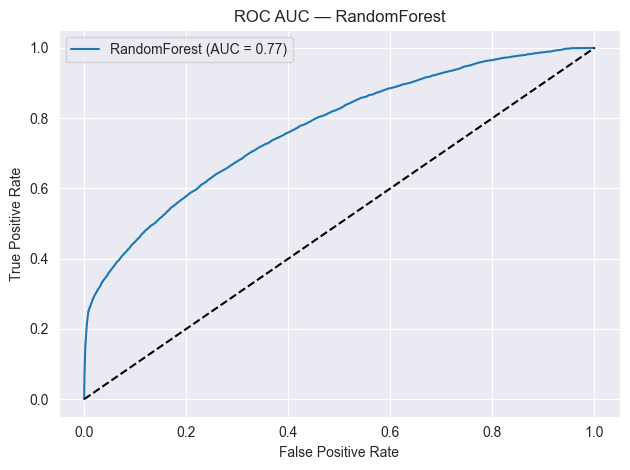


🔎 Feature Importance — RandomForest:



,feature,importance
33,cat__visit_number_encoded_1,0.340441
35,cat__visit_number_encoded_other,0.219984
34,cat__visit_number_encoded_2,0.143119
1,num__utm_source_encoded,0.071596
0,num__utm_campaign_encoded,0.022965
6,cat__utm_medium_mapped_organic,0.022845
37,cat__season_spring,0.019953
30,cat__geo_city_encoded_other,0.012789
2,num__utm_keyword_encoded,0.012165
16,cat__device_os_encoded_other,0.011643


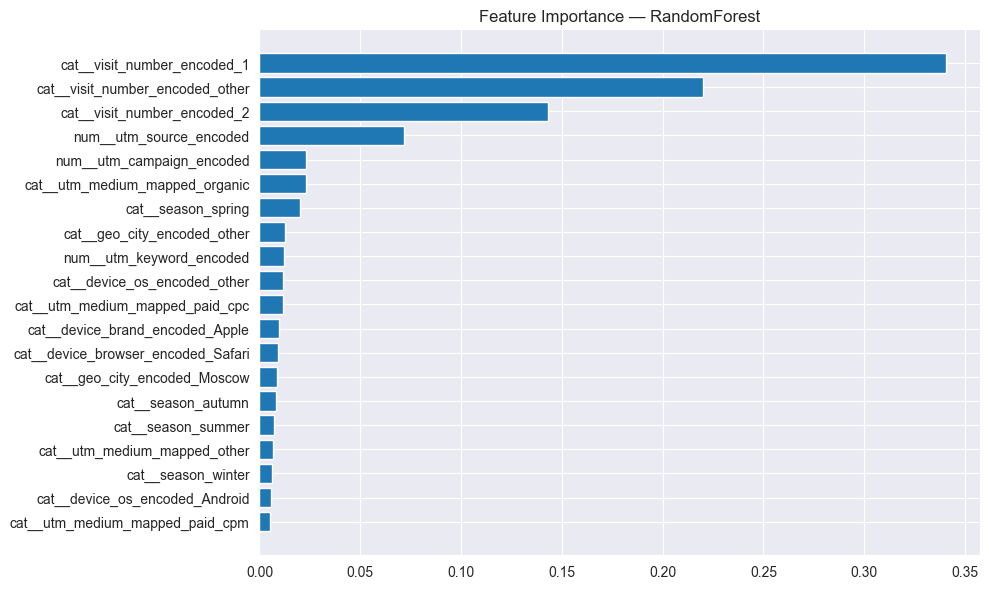

Обучение моделей:  40%|████      | 4/10 [33:17<1:04:28, 644.73s/it]


 GridSearch - GradientBoosting
GradientBoosting ROC AUC: 0.7767
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}


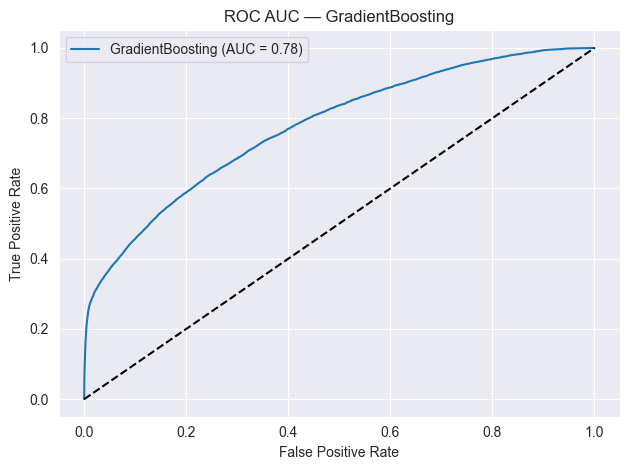


🔎 Feature Importance — GradientBoosting:



,feature,importance
33,cat__visit_number_encoded_1,0.598978
1,num__utm_source_encoded,0.148167
0,num__utm_campaign_encoded,0.039004
37,cat__season_spring,0.023737
35,cat__visit_number_encoded_other,0.020624
2,num__utm_keyword_encoded,0.018956
6,cat__utm_medium_mapped_organic,0.015968
30,cat__geo_city_encoded_other,0.015437
16,cat__device_os_encoded_other,0.014587
38,cat__season_summer,0.011189


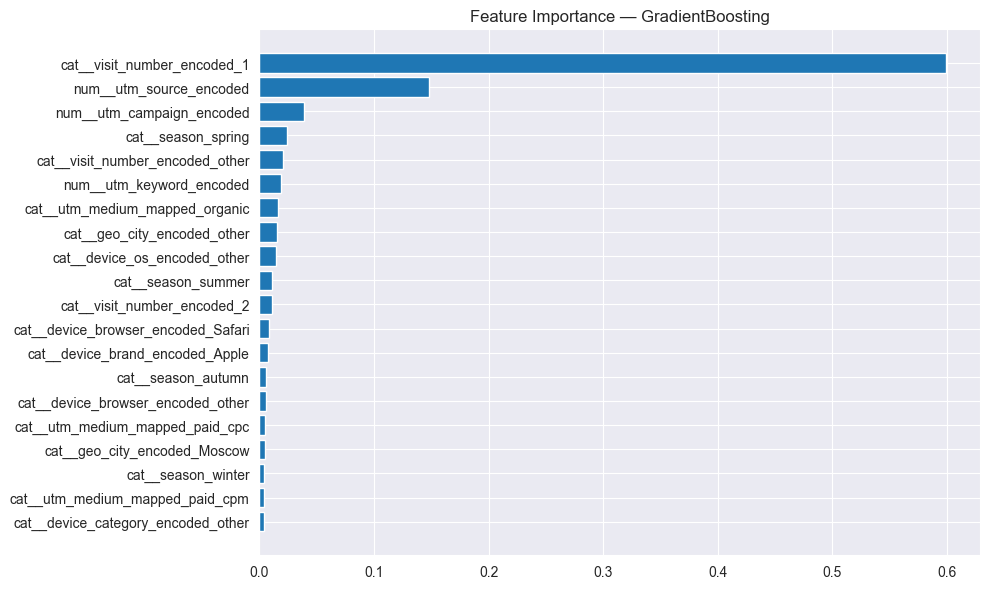

Обучение моделей:  50%|█████     | 5/10 [53:30<1:10:48, 849.71s/it]


 GridSearch - LightGBM
[LightGBM] [Info] Number of positive: 34610, number of negative: 978312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93
[LightGBM] [Info] Number of data points in the train set: 1012922, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034168 -> initscore=-3.341686
[LightGBM] [Info] Start training from score -3.341686
LightGBM ROC AUC: 0.7771
Best params: {'model__learning_rate': 0.1, 'model__max_depth': -1, 'model__n_estimators': 100, 'model__num_leaves': 50}


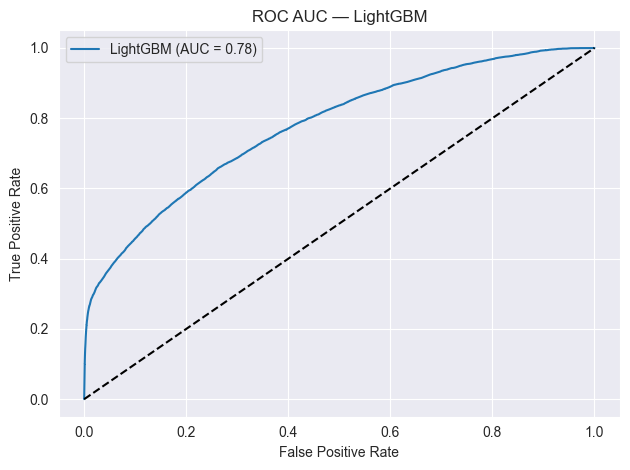


🔎 Feature Importance — LightGBM:



,feature,importance
1,num__utm_source_encoded,654
0,num__utm_campaign_encoded,403
4,num__is_weekend,211
33,cat__visit_number_encoded_1,190
30,cat__geo_city_encoded_other,182
26,cat__device_category_encoded_mobile,177
28,cat__geo_city_encoded_Moscow,162
25,cat__device_browser_encoded_other,153
36,cat__season_autumn,152
2,num__utm_keyword_encoded,150


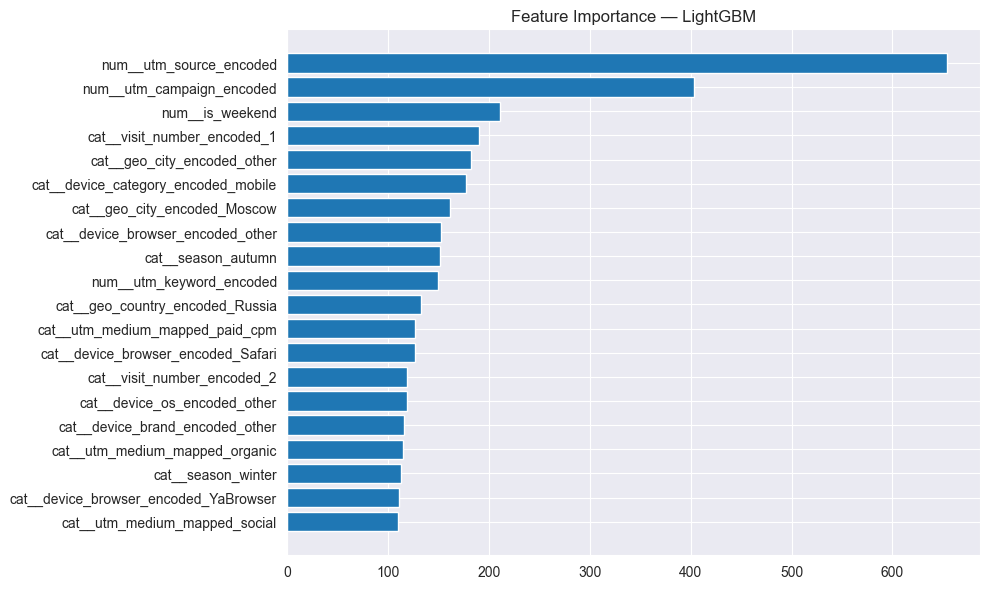

Обучение моделей:  60%|██████    | 6/10 [55:36<40:14, 603.65s/it]  


 GridSearch - XGBoost
XGBoost ROC AUC: 0.7776
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 0.8}


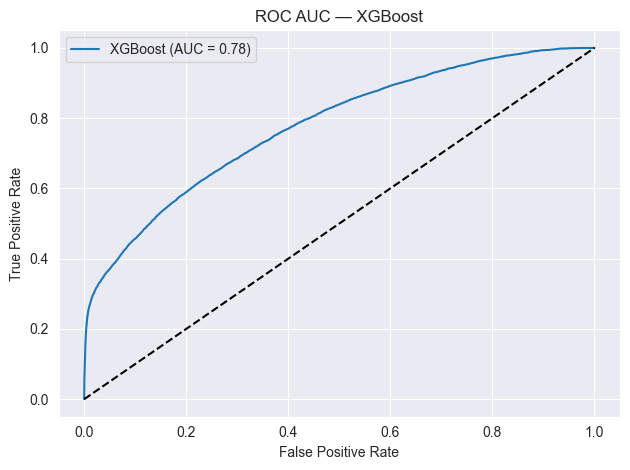


🔎 Feature Importance — XGBoost:



,feature,importance
35,cat__visit_number_encoded_other,0.299149
33,cat__visit_number_encoded_1,0.213719
34,cat__visit_number_encoded_2,0.127241
16,cat__device_os_encoded_other,0.044278
6,cat__utm_medium_mapped_organic,0.031247
1,num__utm_source_encoded,0.030902
37,cat__season_spring,0.020799
0,num__utm_campaign_encoded,0.017759
2,num__utm_keyword_encoded,0.015122
9,cat__utm_medium_mapped_paid_cpm,0.013888


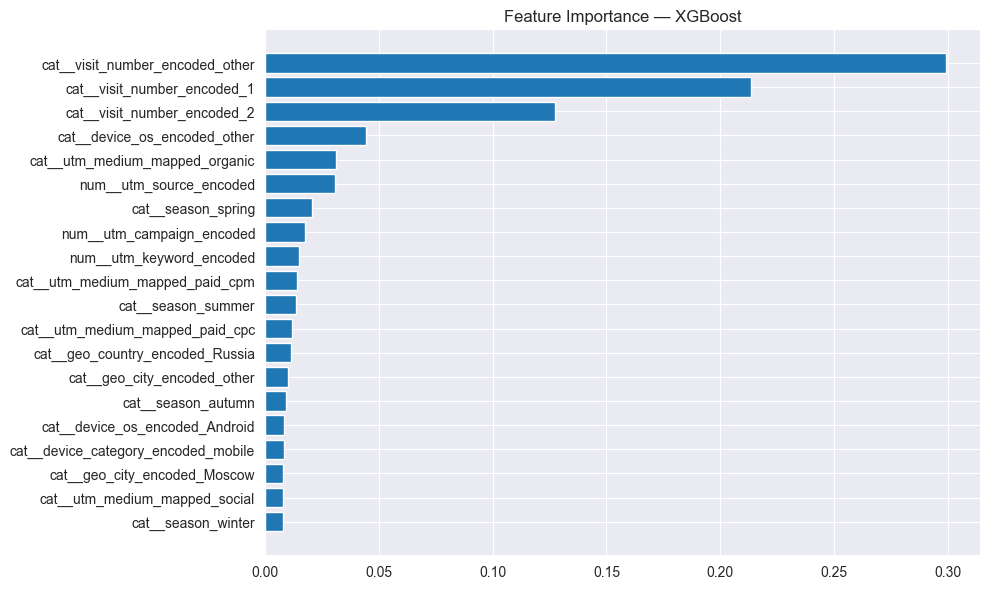

Обучение моделей:  70%|███████   | 7/10 [58:46<23:25, 468.40s/it]


 GridSearch - CatBoost
CatBoost ROC AUC: 0.7745
Best params: {'model__depth': 6, 'model__iterations': 200, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.1}


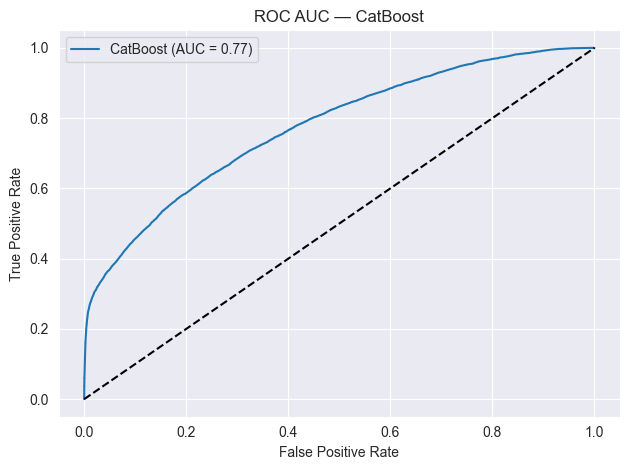


🔎 Feature Importance — CatBoost:



,feature,importance
1,num__utm_source_encoded,24.032867
33,cat__visit_number_encoded_1,11.697246
0,num__utm_campaign_encoded,11.374139
9,cat__utm_medium_mapped_paid_cpm,9.123519
8,cat__utm_medium_mapped_paid_cpc,5.651842
25,cat__device_browser_encoded_other,3.798230
2,num__utm_keyword_encoded,3.487333
37,cat__season_spring,2.755408
16,cat__device_os_encoded_other,2.740933
6,cat__utm_medium_mapped_organic,2.648602


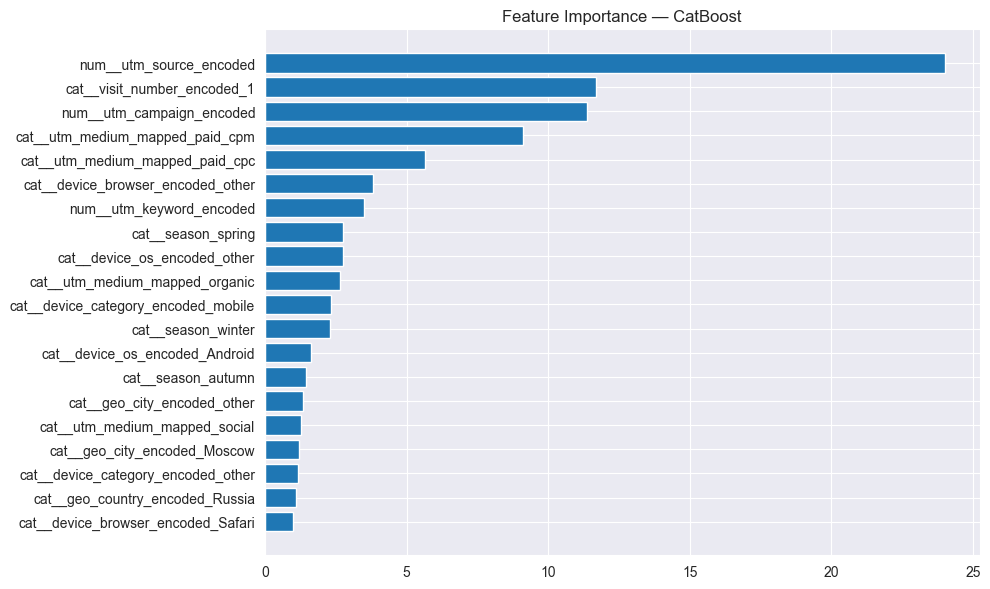

Обучение моделей:  80%|████████  | 8/10 [1:03:00<13:20, 400.07s/it]


 GridSearch - ExtraTrees
ExtraTrees ROC AUC: 0.7664
Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}


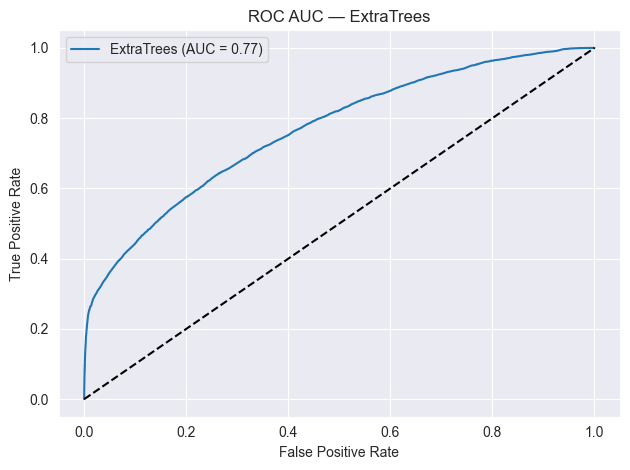


🔎 Feature Importance — ExtraTrees:



,feature,importance
33,cat__visit_number_encoded_1,0.363712
35,cat__visit_number_encoded_other,0.212237
34,cat__visit_number_encoded_2,0.159560
1,num__utm_source_encoded,0.038188
6,cat__utm_medium_mapped_organic,0.029181
37,cat__season_spring,0.018867
8,cat__utm_medium_mapped_paid_cpc,0.015953
30,cat__geo_city_encoded_other,0.014682
0,num__utm_campaign_encoded,0.014194
16,cat__device_os_encoded_other,0.011398


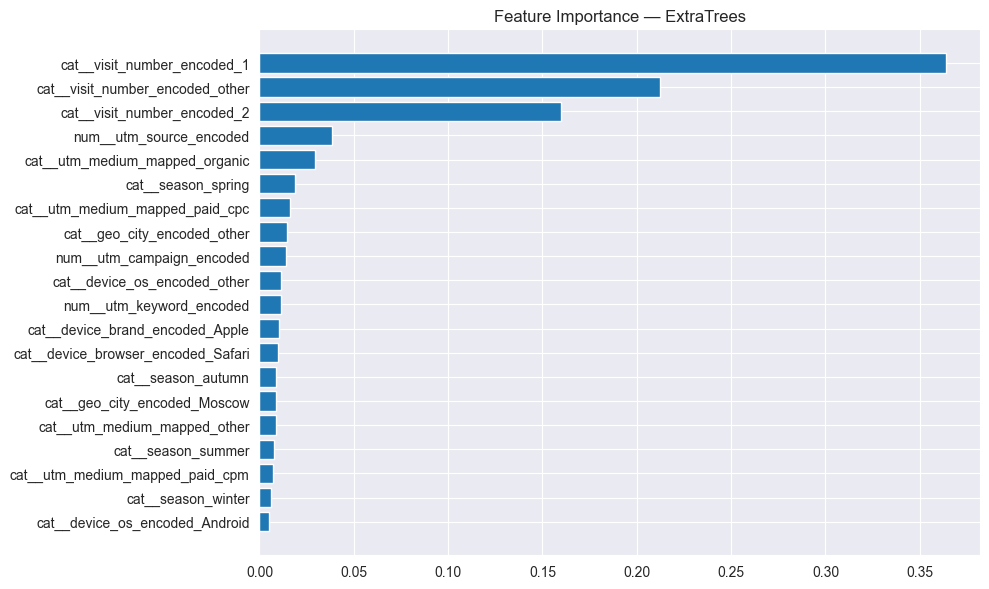

Обучение моделей:  90%|█████████ | 9/10 [1:16:56<08:56, 536.40s/it]


 GridSearch - HistGradientBoosting
HistGradientBoosting ROC AUC: 0.7769
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__max_iter': 200}


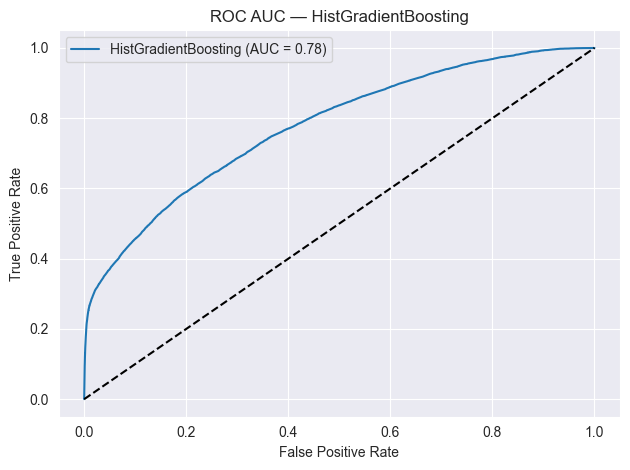

Обучение моделей: 100%|██████████| 10/10 [1:18:29<00:00, 470.92s/it]

Нет фичей для HistGradientBoosting


In [ ]:
auc_scores = train_models_with_grid_search(
    X_train, X_test, y_train, y_test,
    version='v1',
    show_table=True
)

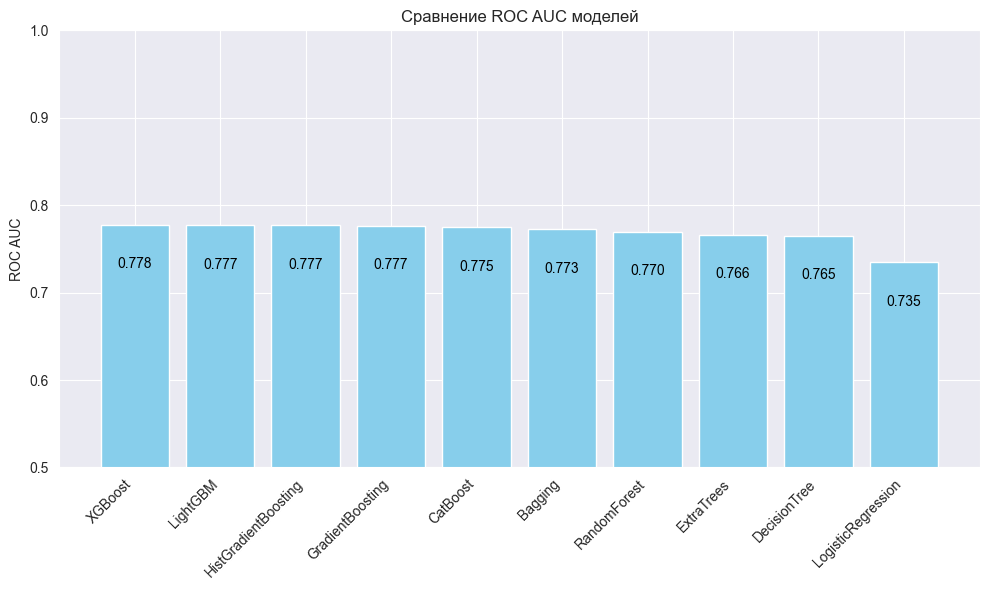

In [ ]:
plot_roc_auc_comparison(auc_scores, 'v1')